# Evaluating the movie lens dataset
The aim of this excecise is to get an understanding on the movie lens dataset as a whole, not individual users or moves. The dataset is loaded in a panda dataframe, to get some overall stats: there is  100k rows, with the columns userId, movieId, rating and timestamp. 

The focus is on rating and timestamp. describe() on rating reveals that the mean is 3.54. We can also see that n.5 rates is less common

#### no of ratings per week 
The ratings is grouped into buckets (weeks) The scatterplot reveals ~5 weeks with >1k ratings. It looks like there is a symmetry when looking at the scatterplot

Another plot is made with accumulated no of ratings. There is one very distinct 'jump'

#### questions left to answer:
- When was n.5 introduced?
- Find the reason for top-rating weeks (new blockbuster movie - or another reason?) 
- There are a couple of weeks that have no ratings. What can be the reason for that? Is there a correlation with top-rating weeks?

In [17]:
from __future__ import print_function, division

import sys

ROOT_PATH = '/Users/asapehrsson/dev/learn/hadoop_spark_jupyter/'

if not [x for x in sys.path if ROOT_PATH in x]:
    sys.path.append(ROOT_PATH + "/code")

import movielens_helper as mh

% matplotlib inline


In [18]:
ratings_df = mh.get_ratings_df(mh.ROOT_PATH)

# short stats - length and first posts
type(ratings_df)
print(ratings_df.shape)
ratings_df.head()


(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [19]:
#stats for all ratings in file. Interesting that mean is >3

ratings_df[mh.RATING_COL_NAME].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [20]:
#how many 5, 4 etc. At some point in time a 10-grade scale is introduced.

ratings_df[mh.RATING_COL_NAME].value_counts().sort_index()

0.5     1101
1.0     3326
1.5     1687
2.0     7271
2.5     4449
3.0    20064
3.5    10538
4.0    28750
4.5     7723
5.0    15095
Name: rating, dtype: int64

In [21]:
#Add column with year-week
ratings_w_y_w_df = mh.add_year_week(ratings_df)
ratings_w_y_w_df.head()

,userId,movieId,rating,timestamp,y_w
0,1,31,2.5,1260759144,200951
1,1,1029,3.0,1260759179,200951
2,1,1061,3.0,1260759182,200951
3,1,1129,2.0,1260759185,200951
4,1,1172,4.0,1260759205,200951


In [22]:
#Find the most active weeks

ratings_per_week_df = ratings_w_y_w_df\
    .groupby(mh.YEAR_WEEK_COL_NAME)[[mh.RATING_COL_NAME]]\
    .count()\
    .sort_values(ascending=False, by=mh.RATING_COL_NAME)

ratings_per_week_df.rename(columns={mh.RATING_COL_NAME:mh.NO_OF_RATINGS_COL_NAME}, inplace=True)

ratings_per_week_df.reset_index(inplace=True, drop=False)
ratings_per_week_df.head()



,y_w,no_of_ratings
0,200047,2603
1,199950,1462
2,201104,1307
3,200512,1261
4,200031,1070


In [23]:
#compare with the least active. A big difference! 

ratings_per_week_df.tail()

,y_w,no_of_ratings
989,201021,1
990,201216,1
991,199842,1
992,201411,1
993,200140,1


In [24]:

all_year_weeks = mh.get_year_weeks_datetime_df(mh.ROOT_PATH, ratings_df)
ratings_per_week_df = mh.fill_in_the_blanks(ratings_per_week_df, all_year_weeks)

ratings_per_week_df.head()


exist


,y_w,ge_timestamp,lt_timestamp,no_of_ratings
0,199502,789652009,790256809,3.0
1,199503,790256809,790861609,0.0
2,199504,790861609,791466409,0.0
3,199505,791466409,792071209,0.0
4,199506,792071209,792676009,0.0


In [25]:
ratings_per_week_df[mh.NO_OF_RATINGS_COL_NAME].describe()

count    1136.000000
mean       88.031690
std       167.534058
min         0.000000
25%         6.000000
50%        26.500000
75%       100.250000
max      2603.000000
Name: no_of_ratings, dtype: float64

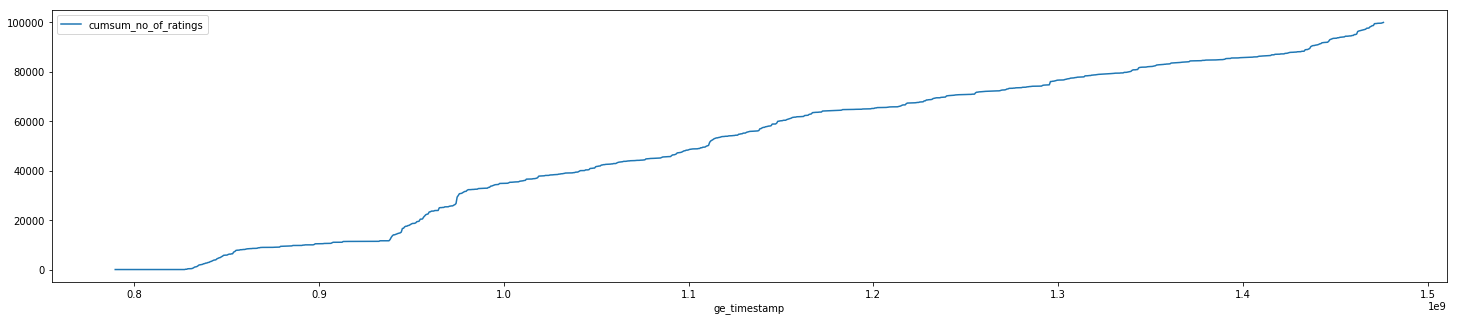

In [27]:
# add accumulated no of rates
ratings_per_week_df[mh.CUMULATIVE_NO_OF_RATINGS_COL_NAME] = ratings_per_week_df[mh.NO_OF_RATINGS_COL_NAME].cumsum()
ratings_per_week_df.plot(y=mh.CUMULATIVE_NO_OF_RATINGS_COL_NAME, x=mh.Y_W_TIMESTAMP_GE_COL_NAME, figsize=[25, 5])

# test with scatter instead of plot
# ratings_per_week_df.loc[ratings_per_week_df[mh.NO_OF_RATINGS_COL_NAME] > 0] \
#    .plot(kind='scatter', x=mh.Y_W_TIMESTAMP_GE_COL_NAME, y=mh.CUMULATIVE_NO_OF_RATINGS_COL_NAME,
#          style=['o', 'rx'], s=1, figsize=[25, 5])


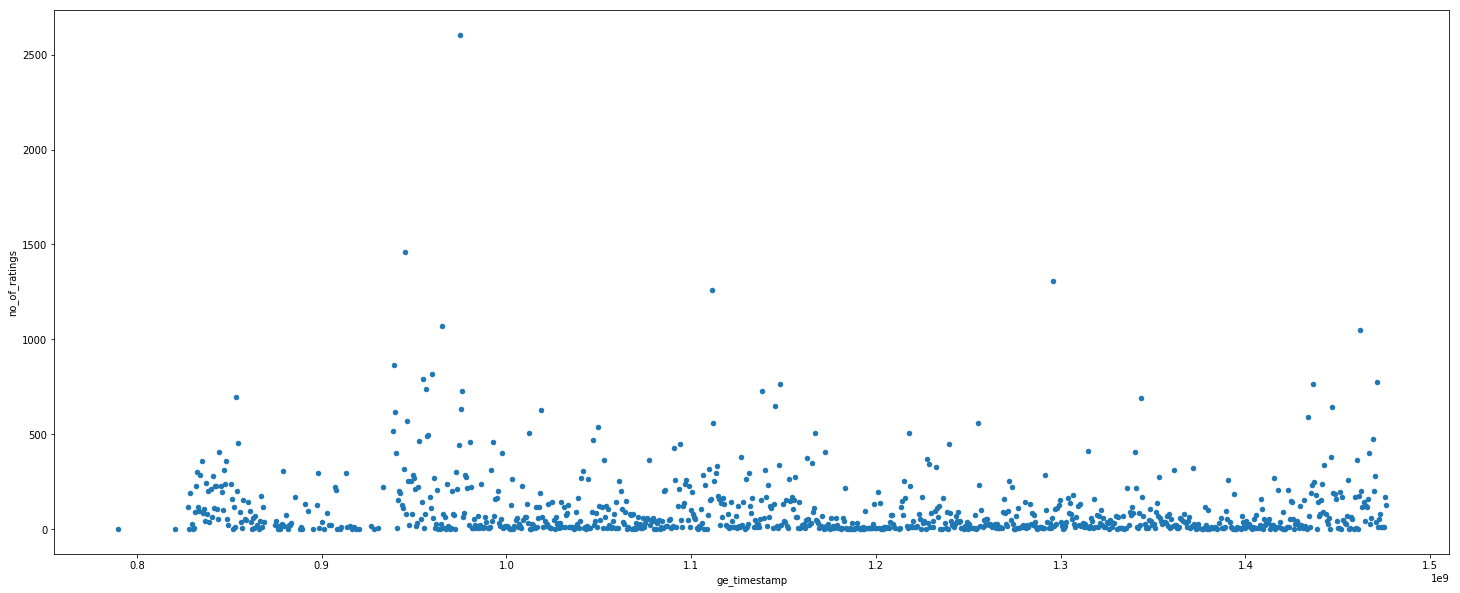

In [28]:
# drop all zero votes

ratings_per_week_df.loc[ratings_per_week_df[mh.NO_OF_RATINGS_COL_NAME] > 0] \
    .plot(kind='scatter', x=mh.Y_W_TIMESTAMP_GE_COL_NAME, y=mh.NO_OF_RATINGS_COL_NAME, figsize=[25, 10])


In [29]:
sorted_on_ratings = ratings_per_week_df.sort_values(ascending=False, by=mh.NO_OF_RATINGS_COL_NAME)

sorted_on_ratings.head()

,y_w,ge_timestamp,lt_timestamp,no_of_ratings,cumsum_no_of_ratings
306,200047,974720809,975325609,2603.0,29324.0
257,199950,945085609,945690409,1462.0,16621.0
837,201104,1295869609,1296474409,1307.0,76090.0
532,200512,1111405609,1112010409,1261.0,51496.0
290,200031,965044009,965648809,1070.0,24982.0


In [30]:
no_ratings_week_df = ratings_per_week_df.loc[ratings_per_week_df[mh.NO_OF_RATINGS_COL_NAME] == 0]
no_ratings_week_df.head()

,y_w,ge_timestamp,lt_timestamp,no_of_ratings,cumsum_no_of_ratings
1,199503,790256809,790861609,0.0,3.0
2,199504,790861609,791466409,0.0,3.0
3,199505,791466409,792071209,0.0,3.0
4,199506,792071209,792676009,0.0,3.0
5,199507,792676009,793280809,0.0,3.0


In [31]:
no_ratings_week_df.tail()

,y_w,ge_timestamp,lt_timestamp,no_of_ratings,cumsum_no_of_ratings
716,200840,1222688809,1223293609,0.0,67494.0
737,200909,1235389609,1235994409,0.0,69515.0
904,201219,1336391209,1336996009,0.0,79797.0
969,201332,1375703209,1376308009,0.0,84514.0
985,201348,1385380009,1385984809,0.0,84836.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


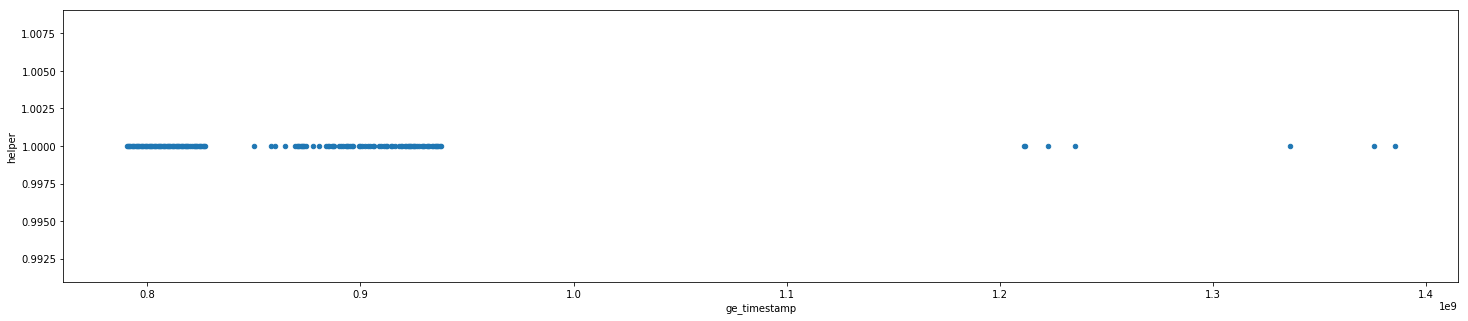

In [32]:
no_ratings_week_df['helper'] = 1
no_ratings_week_df.plot(y='helper', x=mh.Y_W_TIMESTAMP_GE_COL_NAME, figsize=[25, 5], kind='scatter')